In [1]:
import json
import numpy as np
import torch
from utils import groundtruth_replacement, corrupt_non_normal_probabilities, OODDataset, corrupt_probabilities, ModelTrainer,visualize_exact_correct_predictions
from scipy.special import softmax
import os

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Configuration dictionary (replace the JSON file)
config = {
    "cuda_device": 6,
    "data": {
        "Base": "/home/mfaizan/programs/my_project/",
        "TF_Data": "data/transformers/training_multi_mixing/",
        "TF_Save_Path": "data/transformers/trained_models/",
        "tasks": 700,
        "Z_Constant": 0.65
    },
    "dataset": {
        "Perc_OOD": 0.5,
        "num_weak_classifiers": 10,
        "num_of_samples": 10,
        "Samples": 100000
    },
    "training": {
        "NO_WC": 10,
        "model_No": "1",
        "num_models": 1,
        "num_epochs": 1,
        "BATCH_SIZE": 150
    },
    "model": {
        "EMBED_DIM": 768
    }
}

# Set up environment
cuda_device = config["cuda_device"]
os.environ["CUDA_VISIBLE_DEVICES"] = f"{cuda_device}"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Extract subsystems from config
data = config["data"]
dataset = config["dataset"]
training = config["training"]
model_params = config["model"]

# Build paths and hyperparameters
data_folder = f"{data['Base']}{data['TF_Data']}tasks_{data['tasks']}/zipfian_constant_{data['Z_Constant']}/"

# Load datasets
# min = np.load("/home/mfaizan/programs/my_project/data/transformers/normalization/min.npy")
# max = np.load("/home/mfaizan/programs/my_project/data/transformers/normalization/max.npy")
# std = np.load("/home/mfaizan/programs/my_project/data/transformers/normalization/std.npy")
# mean = np.load("/home/mfaizan/programs/my_project/data/transformers/normalization/mean.npy")


Using device: cuda


/home/mfaizan/programs/my_project/src/train_transformers/utils.py:49: RuntimeWarning: divide by zero encountered in scalar divide
  probs[non_gt_indices] = probs[non_gt_indices] * (remaining_prob / np.sum(probs[non_gt_indices]))
/home/mfaizan/programs/my_project/src/train_transformers/utils.py:49: RuntimeWarning: invalid value encountered in multiply
  probs[non_gt_indices] = probs[non_gt_indices] * (remaining_prob / np.sum(probs[non_gt_indices]))


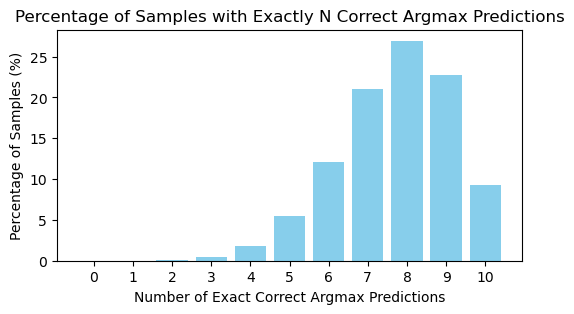

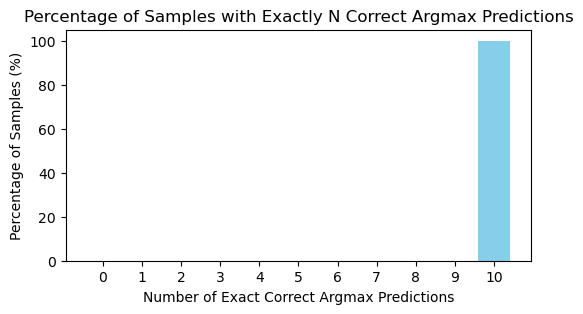

Processing data completed


/home/mfaizan/programs/my_project/src/train_transformers/utils.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  array = array.to('cuda') if isinstance(array, torch.Tensor) and not array.is_cuda else torch.tensor(array).to('cuda')


Dataset created


In [2]:

X_train_ID = np.load(data_folder + "X.npy")
# X_train_ID[:, 0:len(min)] = (X_train_ID[:, 0:len(min)] - mean) / (std)

y_train_ID = np.load(data_folder + "y.npy")
WC_X_train = np.load(data_folder + "wc_output.npy", mmap_mode='r')
# temperature = 2  # Adjust this value as needed
# WC_X_train = softmax(WC_X_train / temperature, axis=2)  # Apply softmax with temperature scaling

# Assuming WC_X_train is already defined
num_samples = WC_X_train.shape[0]

# Generate an array of temperatures, one for each sample, chosen randomly from [1, 1.5, 2, 2.5, 3]
temperature_array = np.random.choice([1, 1.5, 2, 2.5, 3], size=num_samples)

# Reshape temperature_array to match the dimensions of WC_X_train for broadcasting
temperature_array_reshaped = temperature_array[:, np.newaxis, np.newaxis]

# Apply temperature scaling and softmax
scaled_WC_X_train = softmax(WC_X_train / temperature_array_reshaped, axis=2)

WC_X_train = scaled_WC_X_train
Classes = len(np.unique(y_train_ID))
input_dim = X_train_ID.shape[1]

# Process data
normal_indexes = np.where((y_train_ID == 0))[0]
WC_X_train_writable = WC_X_train.copy()
WC_X_train_writable = groundtruth_replacement(WC_X_train_writable, y_train_ID, perc=0.05)

non_normal_WC = WC_X_train_writable[np.where((y_train_ID != 0))[0]]
corrupt_non_normal_WC = corrupt_non_normal_probabilities(non_normal_WC, 0.4)

normal_WC = WC_X_train[normal_indexes]
corrupt_normal_WC = corrupt_probabilities(normal_WC, Classes, 0.0)

WC_X_train_writable[normal_indexes] = corrupt_normal_WC
WC_X_train_writable[np.where((y_train_ID != 0))] = corrupt_non_normal_WC

# visualize_exact_correct_predictions(WC_X_train_writable[np.where((y_train_ID != 0))],y_train_ID[np.where((y_train_ID != 0))[0]])
# visualize_exact_correct_predictions(corrupt_non_normal_WC,y_train_ID[np.where((y_train_ID != 0))[0]])
# visualize_exact_correct_predictions(WC_X_train_writable[normal_indexes] ,y_train_ID[np.where((y_train_ID == 0))[0]])
# visualize_exact_correct_predictions(corrupt_normal_WC,y_train_ID[np.where((y_train_ID == 0))[0]])

print("Processing data completed")

# Create dataset
ID_samples = round((1 - dataset["Perc_OOD"]) * dataset["Samples"])
P_OOD_samples = round(dataset["Perc_OOD"] * dataset["Samples"])
final_dataset = OODDataset(
    X_train_ID, y_train_ID, WC_X_train_writable, 0, ID_samples,
    P_OOD_samples, dataset["num_of_samples"], Classes, dataset["num_weak_classifiers"]
)

print("Dataset created")


In [5]:

# Model and training
model_save_path = f"{data['Base']}{data['TF_Save_Path']}tasks_{data['tasks']}/zipfian_constant_{data['Z_Constant']}/"
print(model_save_path)
print("Training models...")
TF_Model = ModelTrainer(
    model_save_path, training["num_models"], 3, training["BATCH_SIZE"],
    final_dataset, input_dim, Classes, dataset["num_of_samples"],
    training["NO_WC"], device
)
TF_Model.train_and_save_models()


/home/mfaizan/programs/my_project/data/transformers/trained_models/tasks_700/zipfian_constant_0.65/
Training models...


Model 1, Epoch 0:   0%|          | 0/1602 [00:00<?, ?it/s]

accuracy: 0.6726727272727273_precision: 0.5965425095131979_test_loss: 0.5082658997603825_recall: 0.560220659628465
accuracy: 0.7307227272727274_precision: 0.6638744076599333_test_loss: 0.4064636400767735_recall: 0.6414887255625514
accuracy: 0.7500863636363636_precision: 0.6849719649477971_test_loss: 0.3772198664290564_recall: 0.6672424187555467


In [1]:
import json
import numpy as np
import torch
import os
from utils import groundtruth_replacement, corrupt_non_normal_probabilities, OODDataset, corrupt_probabilities, ModelTrainer
from scipy.special import softmax

# Load Configuration
config = {
    "cuda_device": 6,
    "data": {
        "TF_Data": "data/transformers/training_multi_mixing/",
        "TF_Save_Path": "data/transformers/trained_models/TF/"
    },
    "dataset": {
        "Perc_OOD": 0,
        "num_weak_classifiers": 10,
        "num_of_samples": 10,
        "Samples": 1000
    },
    "training": {
        "NO_WC": 10,
        "model_No": "1",
        "num_epochs": 3
    },
    "model": {
        "EMBED_DIM": 768,
        "model_name": "TF"
    }
}

# Define Notebook Variables (Replacing argparse)
base_path = "/home/mfaizan/programs/my_project"  # Change this to your actual base path
tasks = 700  # Adjust as needed
Z_Constant = 0.65  # Adjust as needed
batch_size = 200  # Adjust as needed
num_epochs = 3  # Adjust as needed
num_models = 1  # Adjust as needed

# Set up Environment
cuda_device = config["cuda_device"]
os.environ["CUDA_VISIBLE_DEVICES"] = f"{cuda_device}"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Extract Subsystems from Config
data = config["data"]
dataset = config["dataset"]
training = config["training"]
model_params = config["model"]

model_name = model_params["model_name"]

# Build Paths
data_folder = f"{base_path}/{data['TF_Data']}tasks_{tasks}/zipfian_constant_{Z_Constant}/"

# Load Data
X_train_ID = np.load(data_folder + "X.npy")
y_train_ID = np.load(data_folder + "y.npy")
WC_X_train = np.load(data_folder + "wc_output.npy", mmap_mode='r')

# Apply Temperature Scaling and Softmax
num_samples = WC_X_train.shape[0]
temperature_array = np.random.choice([1, 1.5, 2, 2.5, 3], size=num_samples)
temperature_array_reshaped = temperature_array[:, np.newaxis, np.newaxis]
scaled_WC_X_train = softmax(WC_X_train / temperature_array_reshaped, axis=2)
WC_X_train = scaled_WC_X_train

Classes = len(np.unique(y_train_ID))
input_dim = X_train_ID.shape[1]

# Process Data
normal_indexes = np.where((y_train_ID == 0))[0]
WC_X_train_writable = WC_X_train.copy()

if model_name == "DTF":
    WC_X_train_writable = groundtruth_replacement(WC_X_train_writable, y_train_ID, perc=0.05)
elif model_name == "TF":
    WC_X_train_writable = groundtruth_replacement(WC_X_train_writable, y_train_ID, perc=0.6)

non_normal_WC = WC_X_train_writable[np.where((y_train_ID != 0))[0]]
corrupt_non_normal_WC = corrupt_non_normal_probabilities(non_normal_WC, 0)

normal_WC = WC_X_train[normal_indexes]
corrupt_normal_WC = corrupt_probabilities(normal_WC, Classes, 0.0)

WC_X_train_writable[normal_indexes] = corrupt_normal_WC
WC_X_train_writable[np.where((y_train_ID != 0))] = corrupt_non_normal_WC

print("Processing data completed")

# Create Dataset
ID_samples = round((1 - dataset["Perc_OOD"]) * dataset["Samples"])
P_OOD_samples = round(dataset["Perc_OOD"] * dataset["Samples"])

final_dataset = OODDataset(
    X_train_ID, y_train_ID, WC_X_train_writable, 0, ID_samples,
    P_OOD_samples, dataset["num_of_samples"], Classes, dataset["num_weak_classifiers"], model_name
)

print("Dataset created")




Using device: cuda


/home/mfaizan/programs/my_project/scr/train_transformers/utils.py:43: RuntimeWarning: overflow encountered in scalar divide
  probs[non_gt_indices] = probs[non_gt_indices] * (remaining_prob / np.sum(probs[non_gt_indices]))
/home/mfaizan/programs/my_project/scr/train_transformers/utils.py:43: RuntimeWarning: invalid value encountered in multiply
  probs[non_gt_indices] = probs[non_gt_indices] * (remaining_prob / np.sum(probs[non_gt_indices]))
/home/mfaizan/programs/my_project/scr/train_transformers/utils.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  probs[non_gt_indices] = probs[non_gt_indices] * (remaining_prob / np.sum(probs[non_gt_indices]))


Processing data completed


/home/mfaizan/programs/my_project/scr/train_transformers/utils.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  array = array.to('cuda') if isinstance(array, torch.Tensor) and not array.is_cuda else torch.tensor(array).to('cuda')


Dataset created


In [16]:
# print(len(final_dataset[0]))

sample = 8
print(final_dataset[0][0][sample*2-1,:])
print(final_dataset[0][0][sample*2-2,:])
print(final_dataset[0][1][sample-1])

tensor([219., 629., 219., 219., 219., 220., 219., 219., 219., 219.,  -1.,  -1.,
         -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
         -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
         -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
         -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.])
tensor([-1.7291e-01,  3.1463e-02,  3.6792e-02,  3.2558e+00,  2.0764e-03,
        -2.0917e-01,  8.6562e-02, -7.6106e-03, -5.6630e-02,  2.3738e-02,
        -2.3716e-02, -5.3840e-02,  0.0000e+00, -4.0687e-05,  0.0000e+00,
        -1.6027e-05,  8.2282e-05,  0.0000e+00,  6.7011e-05,  0.0000e+00,
         4.3205e-05, -9.4395e-05, -3.1385e-06, -2.1170e-05,  6.0801e-06,
         3.2105e-06, -8.5948e-06,  3.0258e-06,  2.5721e+03,  1.1745e+03,
         3.4764e+03,  3.4900e+04,  2.7841e-01,  2.7468e+02,  2.6118e+02,
         2.6101e+02,  9.0783e+03,  1.7279e+03,  5.2837e+00,  3.9611e-01,
         2.0995e+00,  3.349

In [2]:
# Define Model Save Path
model_save_path = f"{base_path}/{data['TF_Save_Path']}tasks_{tasks}/zipfian_constant_{Z_Constant}/"
print(f"Model Save Path: {model_save_path}")

# Train Model
print("Training models...")
TF_Model = ModelTrainer(
    model_save_path, num_models, num_epochs, batch_size,
    final_dataset, input_dim, Classes, dataset["num_of_samples"],
    training["NO_WC"], device, model_name=model_name
)
TF_Model.train_and_save_models()

print("Training Completed.")

Model Save Path: /home/mfaizan/programs/my_project/data/transformers/trained_models/TF/tasks_700/zipfian_constant_0.65/
Training models...


Model 1, Epoch 0:   0%|          | 0/12 [00:00<?, ?it/s]

padding_size: padding_size: padding_size: padding_size:     48484848



input_dim: input_dim: input_dim: input_dim:     58585858



torch.Size([11, 48])torch.Size([11, 48])torch.Size([11, 48])torch.Size([11, 48])



(11, 10, 700)(11, 10, 700)(11, 10, 700)(11, 10, 700)



torch.Size([11, 58])torch.Size([11, 58])torch.Size([11, 58])torch.Size([11, 58])



padding_size: padding_size: padding_size: padding_size:     48484848



input_dim: input_dim: input_dim:  input_dim:   58 5858
58

torch.Size([11, 48])
torch.Size([11, 48])
torch.Size([11, 48])torch.Size([11, 48])
(11, 10, 700)

(11, 10, 700)
(11, 10, 700)
(11, 10, 700)
torch.Size([11, 58])
torch.Size([11, 58])
torch.Size([11, 58])
torch.Size([11, 58])padding_size: 
padding_size: 
 padding_size:  padding_size: 48 48 
48
48input_dim: 
input_dim: 
 input_dim:  input_dim: 58 58 
58
58torch.Size([11, 48])
torch.Size([11, 48])

torch.Size([11, 48])
torch.Size([11, 48])(11, 10, 700)
(11, 10, 700)

(11, 10, 700)
(11, 10, 700)
torch.Size([11, 5